## Introduction

Markov Chain Monte Carlo methods are a powerful collection of techniques that allow us to sample from a distribution _even if we can't calculate the distribution directly._ This is useful for complex models, whose distributions may be intractable to compute. The idea is that, if we are able to sample from our desired distribution, we can answer any questions we may have about that distribution.

## What is MCMC?

Our goal is to simulate a Markov chain with a state for each outcome in our probability space. If the stationary distribution of the chain matches the distribution we want to sample from, then a random walk on the chain should perform like a sequence of samples from our desired distribution.

In this lab we will be focusing on the Metropolis-Hastings algorithm, but this is not the only kind of MCMC method. Gibbs sampling, which you may have encountered in CS 188, is also a MCMC method. Gibbs sampling, however, requires computing a conditional distribution for each random variable in your model, which can be impractical and inefficient for some problems.

We'll also explore an application of our algorithm to a sneaky spy challenge: use Metropolis-Hastings to decode the secret messages Gary is sending to Tavor! 🕵️

## Developing Metropolis Hastings (MH)

Our task is to define a set of transition and acceptance probabilities so that we have an aperiodic Markov Chain whose stationary distribution $\pi(x)$ is equal to our target distribution $P(x)$. The MH algorithm does this implicitly by defining a procedure for transitioning between states. However, it has some assumptions. In particular, it assumes that you can compute:

- $f(x)$, **a directly proportional estimate** of $P(x)$, i.e. $P(x) = \frac{f(x)}{\sum_{y \in \mathcal{X}} f(y)}$.
- $g(x, \cdot)$, a proposal distribution for the next state, where $x$ is your current state.

The MH algorithm says, at each time step:

- Propose the next candidate state $y$ according $g(x,\cdot)$.
- Accept $y$, with probability $A(x,y) = min\{1, \frac{f(y)g(y,x)}{f(x)g(x,y)}\}$.
- If you accept the proposal, transition to $y$. Otherwise, stay in $x$.

Following this procedure, the stationary distribution of the implicitly defined Markov Chain will be $P(x)$. Thus you can take a random walk to sample from $P(x)$. However, in practice, the following two extensions are made:

- Taking every step-th state in the random walk. This helps reduce the dependence between samples.
- Letting the chain walk a bit so that the distribution can converge to the stationary distribution.

In [3]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats

import scipy.stats as stats
import math
import matplotlib.pyplot as plt

#######################################
###   PDFs of three distributions   ###
#######################################

def normal(mu,sigma):
    return lambda x: stats.norm.pdf(x,loc = mu, scale = sigma)

def exp(lam):
    return lambda x: lam*math.exp(-lam*x) if x >=0 else 0

def gauss_mix(p,mu1,sig1,mu2,sig2):
    """
    Gaussian mixture with probabilities of selection being p and 1-p for N(mu1,sig1) and N(mu2,sig2) respectively
    """

    return lambda x: p*stats.norm.pdf(x,loc = mu1, scale = sig1) + (1-p)*stats.norm.pdf(x, loc = mu2, scale = sig2)

#######################################
###   Plotting and Graping Utils    ###
#######################################

def plot_histogram_and_transitions(samples):
    plt.hist(samples)
    plt.show()
    plt.plot([i for i in range(len(samples))], samples)
    plt.show()

def plot_transitions(samples):
    plt.plot([i for i in range(len(samples))], samples)
    plt.show()

The cell below implements the Metropolis-Hastings according to the doc string.

In [4]:
def metropolis_hastings(proposal_func, init_func, score_func,
                        num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate candidate states and scorer to
    assign probability scores to candidate
    states.
    
    proposal_func: function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func: function that proposes starting
        state; takes no arguments and returns a
        sample state
    score_func: function that calculates f(y)/f(x)
        * g(y,x)/g(x,y); takes in two state samples
        (the current sample x then the candidate y).
    
    Returns a sequence of every step-th sample. You 
    should sample regardless of whether a transition 
    occurs. The length of the final sequence should 
    be num_iters // step.
    """
    curr = init_func()
    result = []
    for i in range(num_iters):
        proposal = proposal_func(curr)
        score = min(1, score_func(curr, proposal))
        if np.random.rand() < score:
            curr = proposal
        if i % step == 0:
            result.append(curr)
    return result


## Sampling from Distributions Using MH

Now that we have a method for sampling from distributions, let's apply it to some models. We'll start with very simple models so that we can compare the results from sampling with what we can compute analytically.

## A Friendly Gaussian: $\mathcal{N}(60, 1)$

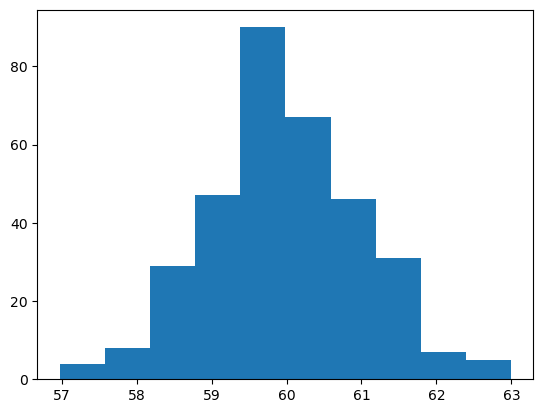

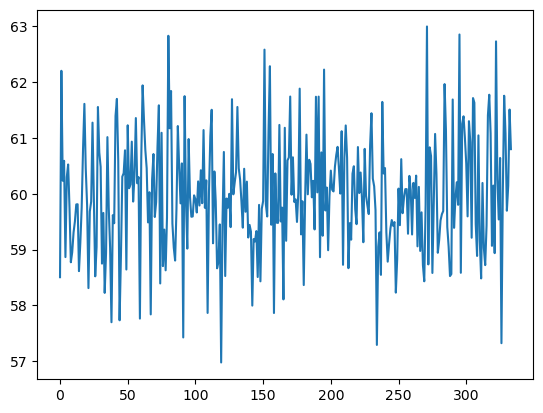

In [5]:
sample_prior = lambda: np.random.normal(loc=60)
sample_candidate = lambda theta: np.random.normal(loc=theta)
scorer = lambda x, y: (math.exp(-((y - 60)**2)/2)) / (math.exp(-((x - 60)**2)/2))
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 10000)
plot_histogram_and_transitions(normal_samples)

## Exponential Distribution: $\mathcal{Exp}(.5)$

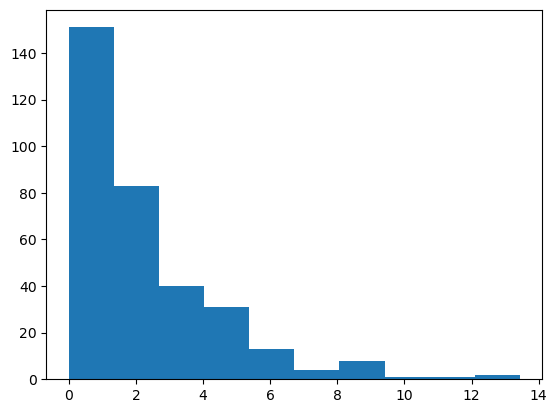

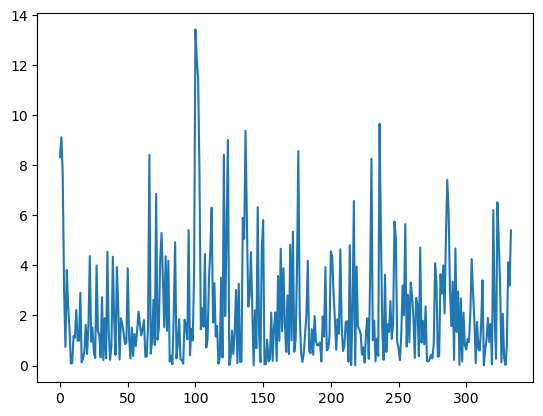

In [6]:
exp_pdf = exp(0.5)
exp_scorer = lambda x,y: exp_pdf(y) / exp_pdf(x)
exp_prior = lambda : 10
exp_samples = metropolis_hastings(sample_candidate, exp_prior, exp_scorer, 10000)
plot_histogram_and_transitions(exp_samples)

## Effects of Initial Distribution, Convergence Diagnosis and Burn-in Time
In the case of the Gaussian above, our `init_function`(initial distribution) was $\mathcal{N}(60,1)$ which is exactly the same as the distribution we were trying to sample, i.e, we started the chain from the stationary distribution. However in general, we obviously don't have the ability to sample from the distribution we were trying to sample from in the first place! Notice that in the exponential, it goes down drastically from 10 where we started the chain, and oscillates more around lower values.

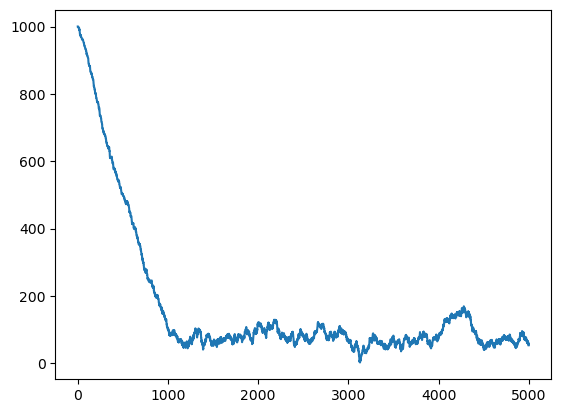

In [7]:
sample_prior = lambda: np.random.normal(loc=1000)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=3)
normal_pdf = normal(60,30)
scorer = lambda x, y: normal_pdf(y) / normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
plot_transitions(normal_samples)

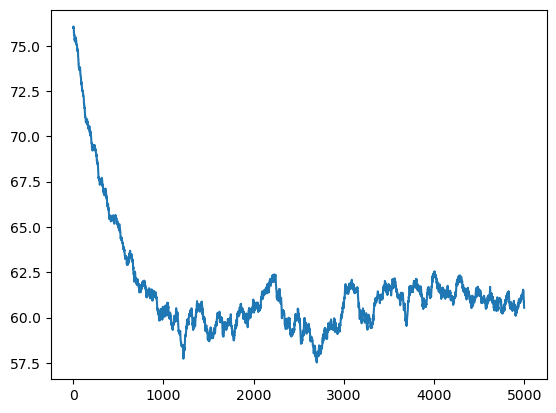

In [8]:
sample_prior = lambda: np.random.normal(loc=75)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=0.1)
normal_pdf = normal(60,1)
scorer = lambda x, y: normal_pdf(y) / normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
plot_transitions(normal_samples)

## Decoding Secret Messages Using MCMC

Now we'll use our algorithm to solve a mystery. Grumpy Gary and Tricky Tavor are sending each other secret messages using a cipher: each character in the message is either an uppercase letter or a space (denoted _ ) (27 possible characters), and their cipher is a one-to-one mapping between the letters of the alphabet + _. To send a message, they replace each character with the corresponding character in their cipher.

For example, if their cipher was the following:

A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | _
- | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | - | -
X | T | A | G | M | L | C | Q | P | Z | H | W | J | I | E | B | K | O | _ | F | D | U | L | N | R | S | Y

Then 'HELLO WORLD' would translate to 'QMWWEYLEOWG'. Your job is to decode their message using the Metropolis-Hastings algorithm you wrote above. Our goal is to find the cipher that maximizes the likelihood of seeing the characters in the translated message. The cipher will be a list of integers representing the letter of the alphabet that the letter corresponding to that index should be translated to. For example, if "g" should be replaced with "a", then $\text{cipher}[6]$ should equal 0. **Note: 0-index when counting letters of the alphabet.**

Our model of language will consider each character to be dependent only on the previous character. For example,

$$\mathbb{P}(x_1 = c, x_2 = a, x_3 = t) = \mathbb{P}(x_1 = c)\mathbb{P}(x_2 = a|x_1 = c)\mathbb{P}(x_3 = t|x_2 = a)$$

These transition probabilities will be calculated empirically by counting the number of transitions between every pair of characters in a large corpus of text.

The state space is the set of all ciphers $X = \{\sigma : \sigma \text{ is a permutation of the English alphabet and '  '}\}$. $|X| = 27!$, so finding the most likely cipher is far too costly to calculate naively, but we can sample from the space of all ciphers intelligently by using Metropolis-Hastings with the following functions:

**Proposals**: To propose new ciphers, we will randomly swap two characters in our cipher.

**Acceptance Function**: Note that because our proposal distribution is symmetric, the acceptance probability becomes $A(x,y) = min\{1, \frac{f(y)}{f(x)}\}$. 
$f(x)$ is the probability of observing the sequence of characters in the message decoded by cipher $x$: 

$$f(\cdot) = \mathbb{P}(x_1 = \text{letter}_1)\mathbb{P}(x_2 = \text{letter}_2|x_1 = \text{letter}_1)\mathbb{P}(x_3 = \text{letter}_3|x_2 = \text{letter}_2)$$

$f(\cdot)$ is _not_ a valid probability over all ciphers because we don't normalize, but it is sufficient for us to compare two ciphers.

Here is an example of one iteration of the algorithm. If we are dealing with a reduced alphabet of $\{A,B,C,D,\text{' '}\}$ and our current cipher is $[ 2,0,4,3,1 ]$, then we are mapping $A->C, B->A, C->\text{' '}$, etc. If our proposal function suggests the perturbed cipher $[ 4,0,2,3,1 ]$, we will accept this cipher as our new state with probability $min \{1, \frac{f([ 4,0,2,3,1 ])}{f([ 2,0,4,3,1 ])}\}$.

We wrote functions to find the bigram frequency matrix, which gives the transition probabilities between characters, and to convert messages into a numerical format. To run the starter code below, you will need to run following cell to download corpus from which we will learn the transition probabilities. This will save a file called `war_and_peace.txt` in the current directory.

In [9]:
# For Linux/MacOS
! curl 'https://www.gutenberg.org/files/2600/2600-0.txt' > war_and_peace.txt
the_secret_message="VTBALNDMNYBQQBSDWVQQUNO RT INVTBLDMNO VYG MNDMNOBNCDAWMGNOG NTWABRWOUNVAINGVO NOGBM NJGBNVR NIWEE R AONVAINDAWSD NVMNWTCBMOBRMNWAMO VINWNQWH NOG NXR VOGNBENER MGNVWRNOGWMNCRBXQ TNCRBZWI MNVMNVNA JNC RMC YOWZ NBANI IDYOWBANOGVONWMNABONR INWMNMDMNR INZ AO IN OYNOGVONGVMNX  ANIBTWAVOWALNOG NPBH MNBENTUNC  RMNVAINOG NZW JNBENTUNE  INU ONXUNORUWALNOBNEBRY NOGWMNCRBXQ TNOBNYBAEBRTNOBNVTBLDMNUBDNUBDRM QENVR NORUWALNOBNYRDMGNBRWLWAVQWOUNVAINDAWSD A MMNVTBALNDMNWMNVNLVT NDQOWTVO QUNYBAZWAYWALNDMNOBNYBAEBRTNOBNT AWVQNQVXBRNVMNOVMHMNVAINVYY CONOG NI VQNBENX WALNPDMONQWH NOG NR MONBENOG NYR JTVO M"
# On Windows download from https://www.gutenberg.org/files/2600/2600-0.txt
# and save as war_and_peace.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3280k  100 3280k    0     0  3138k      0  0:00:01  0:00:01 --:--:-- 3154k


In [10]:
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

def decode(string, ordering):
    """
    Decodes a string according to the given
    ordering.
    
    ordering: a list representing the cipher.
        For example, if in our cipher, 'a'
        should be replaced with 'c', then 
        ordering[0] should equal 2.
    """
    output_str = ""
    for i in string:
        first_char = ord(i.upper()) - 65 if i.isalpha() else 26
        output_str += chr(ordering[first_char] + 65) if ordering[first_char] != 26 else " "
    return output_str

bigram_freq_matrix = build_bigram_freq_matrix(input_file)

### Visualizing the Bigram Frequency Matrix

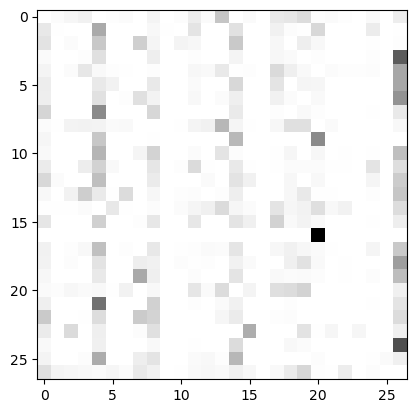

In [11]:
plt.imshow(bigram_freq_matrix, cmap='binary', interpolation='none')    

In [12]:
def starting_state():
    """
    Return a random permutation of indices representing the alphabet.
    """
    return np.random.permutation(27)

assert len(starting_state()) == 27

def sample_candidate(sample):
    """
    To search for new ciphers, create a 
    new cipher from the old cipher with
    two letters swapped.
    
    sample: previous cipher, list
    """
    choices = np.random.choice(27, size=2, replace=False)
    a = choices[0]
    b = choices[1]

    result = sample.copy()

    temp = result[a]
    result[a] = result[b]
    result[b] = temp
    
    return result 

def make_log_f(decode_string, transition_matrix):
    """
    Generates a function which computes the 
    log of the function f in the description 
    (the probability of observing the sequence 
    of characters in the message decoded by 
    cipher x), which is then used to calculate 
    acceptance probabilities.
    
    decode_string: secret message string
    transition_matrix: matrix representing
        transition probabilities from
        char i to char j.
    """

    def log_f(current_sample):
        prod = 0
        past = 0
        decode = lambda x: ord(decode_string[x]) - 65 if decode_string[x].isalpha() else 26
        for i in range(1, len(decode_string)):
            old = current_sample[decode(past)]
            new = current_sample[decode(i)]
            prod += np.log(transition_matrix[old][new])
            past = i
        return prod
    return log_f

def make_acceptance_scorer(log_f):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher devided by the probability of
    observing the message translated by the current
    cipher. See notes above about using log likelihood
    for stability.
    
    log_f: function that computes the log of the probability
        of observing the message translated by the current cipher
    """
    def scorer(current_sample, candidate):
        logged_candidate = log_f(candidate)
        logged_curr = log_f(current_sample)

        ratio = logged_candidate - logged_curr
        return np.exp(ratio)
    return scorer

In [13]:
log_f = make_log_f(the_secret_message, bigram_freq_matrix)
scorer = make_acceptance_scorer(log_f)
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 8000, step=100)

### Watch the Decoding Improve

We print out the first few samples below. As you continue to sample from the space of all ciphers, the quality of your decoding should improve roughly. **You may have to run the algorithm a few times to achieve good results.**


In [14]:
for sample in samples[::len(samples) // 5]:
    print(decode(the_secret_message, sample), '\n')

SVZD ALUABZXXZNLHSXXYAJWOVWTASVZ LUAJWSBIWUALUAJZAELDHUIAJIWAVHDZOHJYASDTAISJWAJIZUWAMIZASOWATHCCWOWDJASDTALDHNLWASUAHVEZUJZOUAHDUJWSTAHAXHFWAJIWAPOWSJIAZCACOWUIASHOAJIHUAEOZPXWVAEOZGHTWUASUASADWMAEWOUEWBJHGWAZDATWTLBJHZDAJISJAHUADZJAOWTAHUAULUAOWTAGWDJWTAWJBAJISJAISUAPWWDATZVHDSJHD AJIWAQZFWUAZCAVYAEWWOUASDTAJIWAGHWMAZCAVYACWWTAYWJAPYAJOYHD AJZACZOBWAJIHUAEOZPXWVAJZABZDCZOVAJZASVZ LUAYZLAYZLOUWXCASOWAJOYHD AJZABOLUIAZOH HDSXHJYASDTALDHNLWDWUUASVZD ALUAHUASA SVWALXJHVSJWXYABZDGHDBHD ALUAJZABZDCZOVAJZAVWDHSXAXSPZOASUAJSUFUASDTASBBWEJAJIWATWSXAZCAPWHD AQLUJAXHFWAJIWAOWUJAZCAJIWABOWMVSJWU 

AMONG US COLLOZUIALLY TERMED AMOGUS TEACHES US TO PUNISH THE MINORITY AND HATE THOSE WHO ARE DIFFERENT AND UNIZUE AS IMPOSTORS INSTEAD I LIKE THE BREATH OF FRESH AIR THIS PROBLEM PROVIDES AS A NEW PERSPECTIVE ON DEDUCTION THAT IS NOT RED IS SUS RED VENTED ETC THAT HAS BEEN DOMINATING THE JOKES OF MY PEERS AND THE VIEW OF MY FEED YET BY TRYING TO FORCE THIS PROBLEM TO CONFORM TO AMOGUS YOU YOURSELF ARE 

What did Gary's secret message to Tavor say?

In [15]:
log_probs = [log_f(s) for s in samples]
print(len(log_probs))
best_cipher_index = np.argmax(log_probs)
print(decode(the_secret_message, samples[best_cipher_index]).upper())

80
AMONG US COLLOQUIALLY TERMED AMOGUS TEACHES US TO PUNISH THE MINORITY AND HATE THOSE WHO ARE DIFFERENT AND UNIQUE AS IMPOSTORS INSTEAD I LIKE THE BREATH OF FRESH AIR THIS PROBLEM PROVIDES AS A NEW PERSPECTIVE ON DEDUCTION THAT IS NOT RED IS SUS RED VENTED ETC THAT HAS BEEN DOMINATING THE JOKES OF MY PEERS AND THE VIEW OF MY FEED YET BY TRYING TO FORCE THIS PROBLEM TO CONFORM TO AMOGUS YOU YOURSELF ARE TRYING TO CRUSH ORIGINALITY AND UNIQUENESS AMONG US IS A GAME ULTIMATELY CONVINCING US TO CONFORM TO MENIAL LABOR AS TASKS AND ACCEPT THE DEAL OF BEING JUST LIKE THE REST OF THE CREWMATES


[1] https://people.eecs.berkeley.edu/~sinclair/cs294/n1.pdf

[2] http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf

[3] http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf